<a href="https://colab.research.google.com/github/jihye-kim11/AI_project/blob/master/%EC%9B%94%EA%B0%84%EB%8D%B0%EC%9D%B4%EC%BD%9814.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [3]:
!cp "/content/drive/MyDrive/신용카드 연체 예측 데이터/train.csv" "/content/data/train.csv"
!cp "/content/drive/MyDrive/신용카드 연체 예측 데이터/test.csv" "/content/data/test.csv"
!cp "/content/drive/MyDrive/신용카드 연체 예측 데이터/sample_submission.csv" "/content/data/sample_submission.csv"

In [4]:
import pandas as pd

In [5]:
train = pd.read_csv("/content/data/train.csv")
test = pd.read_csv("/content/data/test.csv")
sample_submission = pd.read_csv("/content/data/sample_submission.csv")

In [6]:
train.shape

(26457, 20)

In [7]:
test.shape

(10000, 19)

#데이터 전처리

##1)결측치 제거

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [9]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [10]:
data = pd.concat([train, test], axis = 0)

In [11]:
data.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
occyp_type       11323
family_size          0
begin_month          0
credit           10000
dtype: int64

occyp_type(직업유형)은 null값인 케이스가 너무 많고, 그 데이터 종류가 다양하여 분석하기 어려우므로 삭제시킨다.

In [12]:
data = data.drop("occyp_type", axis = 1)

In [13]:
data.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
family_size          0
begin_month          0
credit           10000
dtype: int64

##2)고유값명 변경-고유값 2가지인 경우

다음으로  각 데이터 변수의 고유값 개수를 확인해보자.

In [14]:
unique_len = data.apply(lambda x : len(x.unique()))
unique_len

index            36457
gender               2
car                  2
reality              2
child_num            9
income_total       265
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        7183
DAYS_EMPLOYED     3640
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
family_size         10
begin_month         61
credit               4
dtype: int64


```
gender:F,M  성별 -:>1,0
car:N,Y 차량 소유 여부 ->0,1
reality:N,Y 부동산 소유 여부 ->0,1
FLAG_MOBIL:1 핸드폰 소유 여부
work_phone:0,1 업무용 전화 소유 여부
phone:0,1 전화 소유 여부
email:0,1 이메일 소유 여부
```

다음과 같이 변경해준다



In [15]:
data['gender'] = data['gender'].replace(['F','M'],[0,1])
data['car'] = data['car'].replace(['N','Y'],[0,1])
data['reality'] = data['reality'].replace(['N','Y'],[0,1])

##3)고유값명 변경-child_num

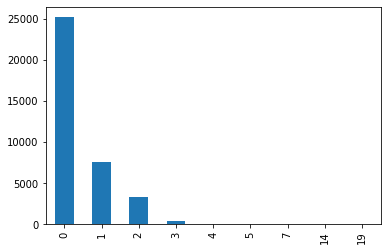

In [16]:
data['child_num'].value_counts(sort=False).plot.bar()

child_num 데이터는 실질적으로는 0,1,2,3,밖에 없다. 이는 이 데이터가 중국에서 조사한 데이터인데 중국의 산아제한정책때문에 이러한 데이터 형태가 발생한 듯 하다.

2보다 큰 데이터는 매우 적어 무의미하므로 2보다 큰 경우 2로 수정해주자.

In [17]:
data.loc[data['child_num'] > 2, 'child_num'] = 2

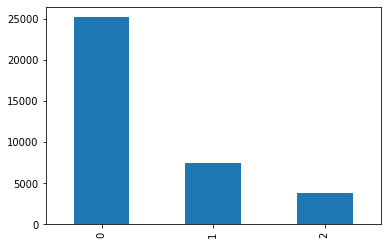

In [18]:
data["child_num"].value_counts().plot.bar()

##4)고유값명 변경-income_total

In [19]:
print(data['income_total'].value_counts(bins=10,sort=False))

(25451.999, 181800.0]     22460
(181800.0, 336600.0]      11380
(336600.0, 491400.0]       2099
(491400.0, 646200.0]        274
(646200.0, 801000.0]        165
(801000.0, 955800.0]         58
(955800.0, 1110600.0]         4
(1110600.0, 1265400.0]        3
(1265400.0, 1420200.0]        6
(1420200.0, 1575000.0]        8
Name: income_total, dtype: int64


다음은 연간 소득 데이터이다. 모든 데이터가 10000을 넘으므로 /10000을 해주고 앞으로 모든 데이터 뒤에 '만'을 붙여서 읽도록 하자

(2.544, 18.18]      22460
(18.18, 33.66]      11380
(33.66, 49.14]       2099
(49.14, 64.62]        274
(64.62, 80.1]         165
(80.1, 95.58]          58
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income_total, dtype: int64


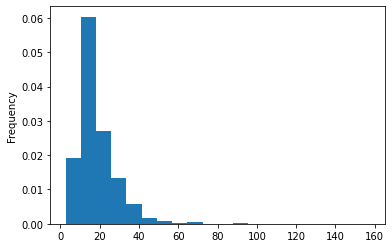

In [20]:
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=20,density=True)

##5)고유값명 변경-type

In [21]:
print(data['income_type'].unique())
print(data['edu_type'].unique())
print(data['family_type'].unique())
print(data['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


type 데이터들의 고유값을 0,1,2,,, 형태로 변경한다

In [22]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
data['income_type']=label_encoder.fit_transform(data['income_type'])
data['edu_type']=label_encoder.fit_transform(data['edu_type'])
data['family_type']=label_encoder.fit_transform(data['family_type'])
data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])

In [23]:
data

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,158,0,1,1,2,-13899,-4709,1,0,0,0,2.0,-6.0,1.0
1,1,0,0,1,1,180,0,4,0,1,-11380,-1540,1,0,0,1,3.0,-5.0,1.0
2,2,1,1,1,0,230,4,1,1,1,-19087,-4434,1,0,1,0,2.0,-22.0,2.0
3,3,0,0,1,0,158,0,4,1,1,-15088,-2092,1,0,1,0,2.0,-37.0,0.0
4,4,0,1,1,0,120,2,1,1,1,-15037,-2105,1,0,0,0,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,158,4,2,1,1,-18593,-5434,1,1,1,0,2.0,-19.0,NaN
9996,36453,1,1,1,0,158,4,4,0,1,-10886,-1315,1,1,0,0,2.0,-34.0,NaN
9997,36454,0,0,1,0,197,4,4,1,1,-21016,-14018,1,0,0,0,2.0,-55.0,NaN
9998,36455,0,1,0,0,145,0,4,1,1,-16541,-1085,1,0,1,0,2.0,-33.0,NaN


##6)고유값명 변경-DAYS_BIRTH,DAYS_EMPLOYED,begin_month

고유값이 매우 많은 데이터들을 각 구간별로 구분하여 라벨화시켜주자

In [24]:
print(data['DAYS_BIRTH'].value_counts(bins=10,sort=False))
print(data['DAYS_EMPLOYED'].value_counts(bins=10,sort=False))
print(data['begin_month'].value_counts(bins=10,sort=False))


(-25169.664, -23385.7]    1252
(-23385.7, -21619.4]      3252
(-21619.4, -19853.1]      3713
(-19853.1, -18086.8]      3934
(-18086.8, -16320.5]      4063
(-16320.5, -14554.2]      5015
(-14554.2, -12787.9]      5177
(-12787.9, -11021.6]      4922
(-11021.6, -9255.3]       4248
(-9255.3, -7489.0]         881
Name: DAYS_BIRTH, dtype: int64
(-16093.957, 22382.6]    30322
(22382.6, 60478.2]           0
(60478.2, 98573.8]           0
(98573.8, 136669.4]          0
(136669.4, 174765.0]         0
(174765.0, 212860.6]         0
(212860.6, 250956.2]         0
(250956.2, 289051.8]         0
(289051.8, 327147.4]         0
(327147.4, 365243.0]      6135
Name: DAYS_EMPLOYED, dtype: int64
(-60.061, -54.0]    2336
(-54.0, -48.0]      2653
(-48.0, -42.0]      2893
(-42.0, -36.0]      3489
(-36.0, -30.0]      3518
(-30.0, -24.0]      3961
(-24.0, -18.0]      4104
(-18.0, -12.0]      4684
(-12.0, -6.0]       4929
(-6.0, 0.0]         3890
Name: begin_month, dtype: int64


각 데이터들의 구성 요소를 살펴보니, DAYS_EMPLOYED는 음수와 양수가 섞여있음을 확인할 수 있었다.

이는 음수는 카드 발급 당시 음수의 수만큼 이미 일을 시작한 시간이 지났다는 것이고,
양수 값은 고용되지 않았음을 의미한다.

In [25]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    data[variable]=-data[variable]
    count, bin_dividers =np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data[variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data[variable]=label_encoder.fit_transform(data[variable])

In [26]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)


3    5177
4    5015
2    4922
1    4248
5    4063
6    3934
7    3713
8    3252
9    1252
0     881
Name: DAYS_BIRTH, dtype: int64


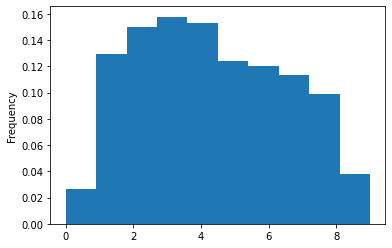

In [27]:
print(data['DAYS_BIRTH'].value_counts())
data['DAYS_BIRTH'].plot(kind='hist',density=True)

1    30322
0     6135
Name: DAYS_EMPLOYED, dtype: int64


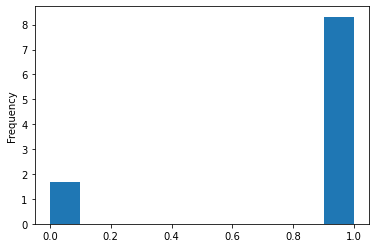

In [28]:
print(data['DAYS_EMPLOYED'].value_counts())
data['DAYS_EMPLOYED'].plot(kind='hist',density=True)

일단 유직(0)/무직(1)상태로 나눠서 살펴보자

0    11911
1    10274
2     8355
3     5917
Name: begin_month, dtype: int64


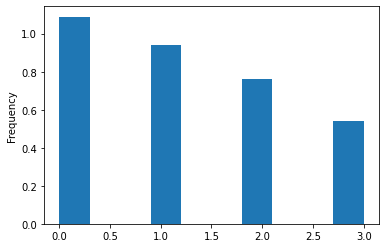

In [29]:
print(data['begin_month'].value_counts())
data['begin_month'].plot(kind='hist',density=True)

In [30]:
data

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,158,0,1,1,2,3,1,1,0,0,0,2.0,0,1.0
1,1,0,0,1,1,180,0,4,0,1,2,1,1,0,0,1,3.0,0,1.0
2,2,1,1,1,0,230,4,1,1,1,6,1,1,0,1,0,2.0,1,2.0
3,3,0,0,1,0,158,0,4,1,1,4,1,1,0,1,0,2.0,2,0.0
4,4,0,1,1,0,120,2,1,1,1,4,1,1,0,0,0,2.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,158,4,2,1,1,6,1,1,1,1,0,2.0,1,NaN
9996,36453,1,1,1,0,158,4,4,0,1,1,1,1,1,0,0,2.0,2,NaN
9997,36454,0,0,1,0,197,4,4,1,1,7,1,1,0,0,0,2.0,3,NaN
9998,36455,0,1,0,0,145,0,4,1,1,5,1,1,0,1,0,2.0,2,NaN


#데이터 모델링

In [31]:
len(data)

36457

In [32]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]

In [33]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

In [34]:
print(train_x.shape, train_y.shape, test_x.shape)

(26457, 18) (26457, 1) (10000, 18)
